In [4]:
from create_coinset import CoinQuery, ImageParams
from coin_loader import AncientCoins
from coin_model import BasicCNN, ResNet, TrainModel
import coin_loader
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import homogeneity_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms, models
import os
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
import UnsupervisedRandomForest as URF

In [5]:
#Set to True if dataset should be created
create = False

if create:
    #Create default dataset in folder 'Resnet_Coinset'
    conn = sql.connect(**cf.config)
    coin_query = CoinQuery(conn)
    image_params = ImageParams(size=256)
    coin_query.create_dataset('Resnet_Coinset', image_params)
    conn.close()

In [6]:
# Set the device to cuda if a GPU is available
is_gpu = torch.cuda.is_available()
device = torch.device("cuda" if is_gpu else "cpu")
#Set the desired image size (according to CNN requirements)
img_size = 224

transform = [
            transforms.ToPILImage(),
            transforms.Resize((img_size,img_size)),
            transforms.RandomHorizontalFlip(),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor()]

dataset = AncientCoins("Coinset", img_size, is_gpu, transform=transform)
num_classes = len(dataset.labels.keys())

In [7]:
resnet = ResNet(num_classes)

In [8]:
#Changed topk to 2 for MNIST
trainer = TrainModel(device, dataset.trainloader, dataset.valloader, resnet.model, epochs=5)

EPOCH: 1
TRAIN
Loss 3.6780 (3.6780)	Prec@1 0.000 (0.000)
VALIDATION
 * Validation accuracy: Prec@1 53.893 
EPOCH: 2
TRAIN
Loss 0.7640 (0.7640)	Prec@1 81.250 (81.250)
VALIDATION
 * Validation accuracy: Prec@1 64.344 
EPOCH: 3
TRAIN
Loss 0.6211 (0.6211)	Prec@1 81.250 (81.250)
VALIDATION
 * Validation accuracy: Prec@1 65.164 
EPOCH: 4
TRAIN
Loss 0.1742 (0.1742)	Prec@1 96.875 (96.875)
VALIDATION
 * Validation accuracy: Prec@1 67.213 
EPOCH: 5
TRAIN
Loss 0.2450 (0.2450)	Prec@1 90.625 (90.625)
VALIDATION
 * Validation accuracy: Prec@1 74.385 


In [9]:
idxs, output, targets = resnet.feature_extraction(dataset.valloader)

## Unsupervised Random Forest Clustering
Computation of a proximity matrix using Random Forest, followed by DBSCAN proximity clustering.
T-SNE dimension reduction technique used for visualization purposes

In [10]:
urf = URF.UnsupervisedRandomForest()
urf.fit(np.array(output))

proximities = urf.create_proximity(np.array(output))
print(proximities)

[[0.   0.98 0.88 ... 0.95 0.87 0.96]
 [0.98 0.   0.93 ... 0.71 0.97 0.87]
 [0.88 0.93 0.   ... 0.92 0.88 0.92]
 ...
 [0.95 0.71 0.92 ... 0.   0.94 0.89]
 [0.87 0.97 0.88 ... 0.94 0.   0.99]
 [0.96 0.87 0.92 ... 0.89 0.99 0.  ]]


In [11]:
eps = 0.61
min_samples = 5

clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(proximities)
core_samples_mask = np.zeros_like(clustering.labels_, dtype=bool)
core_samples_mask[clustering.core_sample_indices_] = True
labels = clustering.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)        

unique_labels = set(labels)

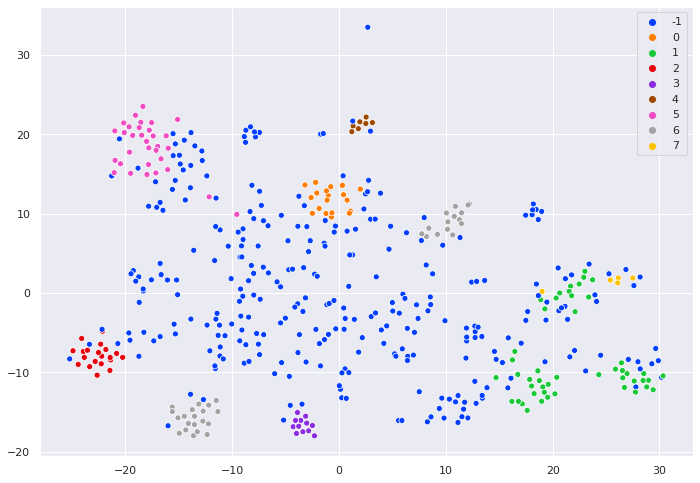

In [12]:
palette = sns.color_palette("bright", len(unique_labels))

tsne = TSNE().fit_transform(output)
sns.scatterplot(tsne[:,0], tsne[:,1], hue=labels, legend='full', palette=palette)

## K-Means Clustering
Partition clustering followed by insights into the clusters

In [13]:
min_cluster = 39
max_cluster = 40
for k in range(min_cluster, max_cluster):
    kmeans_model = KMeans(n_clusters=k, random_state=1).fit(output)
    inertia = kmeans_model.inertia_
    labels = kmeans_model.labels_
    print ("k: ", k, " cost: ", inertia)
    
print("Homogeneity Score: {}".format(homogeneity_score(labels, targets)))

k:  39  cost:  64222.58984375
Homogeneity Score: 0.7364624699204017


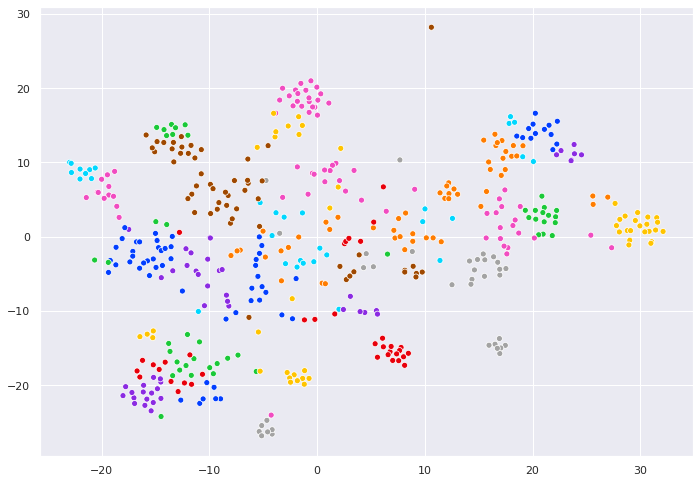

In [14]:
palette = sns.color_palette("bright", len(set(labels)))

tsne = TSNE().fit_transform(output)
sns.scatterplot(tsne[:,0], tsne[:,1], hue=labels, legend=False, palette=palette)

## Cluster Assignments and homogeneities
We compute the similarity between the clusters and ground truth labels, in order to create a most likely assignment dictionary between the labels and the clusters. The similarity is described in terms of homogeneity, which we compute as the amount of correctly assigned coins within a class, divided by the number of coins in that class.

In [15]:
def cluster2truth(label, true_labels, cluster_labels):
    potential_clusters = {}
    
    for coin in true_labels[label]:            
        for k in cluster_labels.keys():
            if coin in cluster_labels[k]:
                if k in potential_clusters:
                    potential_clusters[k] += 1
                else:
                    potential_clusters[k] = 1
                    
    max_homogeneity = -1
    cluster = -1
    for k in potential_clusters.keys():
        if potential_clusters[k] > max_homogeneity:
            max_homogeneity = potential_clusters[k]
            cluster = k            
    
    return cluster, round(max_homogeneity/len(true_labels[label]),3)

In [16]:
cluster_labels = {}
true_labels = {}

for i, t in enumerate(targets):
    if targets[i] not in true_labels:
        true_labels[targets[i]] = set()
    true_labels[targets[i]].add(i)
    if labels[i] not in cluster_labels:
        cluster_labels[labels[i]] = set()
    cluster_labels[labels[i]].add(i)

In [17]:
cluster_assignments = {}
cluster_homogeneities = {}

for label in set(true_labels):
    cluster_assignments[label], cluster_homogeneities[label] = cluster2truth(label, true_labels, cluster_labels)
    
print(cluster_assignments)
print(cluster_homogeneities)

{0: 10, 1: 26, 2: 1, 3: 31, 4: 32, 5: 0, 6: 23, 7: 26, 8: 4, 9: 20, 10: 32, 11: 5, 12: 33, 13: 34, 14: 10, 15: 12, 16: 3, 17: 6, 18: 25, 19: 32, 20: 1, 21: 34, 22: 27, 23: 37, 24: 18, 25: 30, 26: 31, 27: 15, 28: 35, 29: 21, 30: 14, 31: 8, 32: 24, 33: 16, 34: 13, 35: 17, 36: 5, 37: 38, 38: 16}
{0: 0.8, 1: 0.75, 2: 0.5, 3: 0.4, 4: 0.6, 5: 0.286, 6: 0.5, 7: 0.4, 8: 0.64, 9: 0.857, 10: 0.6, 11: 0.44, 12: 0.5, 13: 0.6, 14: 0.25, 15: 0.812, 16: 0.3, 17: 0.8, 18: 0.526, 19: 0.6, 20: 0.5, 21: 0.368, 22: 0.778, 23: 0.778, 24: 0.818, 25: 0.562, 26: 0.417, 27: 0.364, 28: 0.5, 29: 0.55, 30: 0.7, 31: 0.84, 32: 1.0, 33: 0.5, 34: 1.0, 35: 0.64, 36: 0.4, 37: 0.5, 38: 0.25}


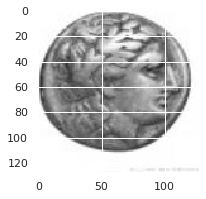

In [52]:
import skimage.io as io
cluster = 0
idx = 365
filename = os.path.join("Coinset/" + str(cluster), dataset.test_X[idx])
image = io.imread(filename)
plt.figure(figsize=(3,3))
io.imshow(image)